# Introduction

The proposed project focuses on utilizing Convolutional Neural Networks (CNN) for Histopathologic Cancer Detection, an essential aspect of medical diagnostics. Histopathologic analysis involves the microscopic examination of tissue samples to identify disease-related indicators, such as cancer. By employing CNNs in this field, the goal is to automate and improve the accuracy of cancer cell detection in histopathology images.The primary challenge is to design a CNN model capable of recognizing subtle patterns and features in histopathologic slides that signify the presence of cancer. This task is intricate due to the intricate nature of tissue structures and the subtle variations that distinguish between benign and malignant cells.

The dataset selected for this project, obtained from Cukierski (2018) via a Kaggle competition, consists of numerous annotated high-resolution images of lymph node sections. Each image is carefully labeled, highlighting the presence of metastatic tissue – a crucial indicator of cancer. The overarching aim is to leverage deep learning techniques, specifically CNNs, to enhance the efficiency and accuracy of cancer detection in histopathology, ultimately contributing to improved diagnostic processes in the medical field.

# Explaratory Data Analysis and Cleanup

In this section, we'll try to explore the data as well as prepare it to be used for the models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os

BASE_DIR = '/kaggle/input/histopathologic-cancer-detection/'

train_df = pd.read_csv(BASE_DIR + 'train_labels.csv')
train_df.head()

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


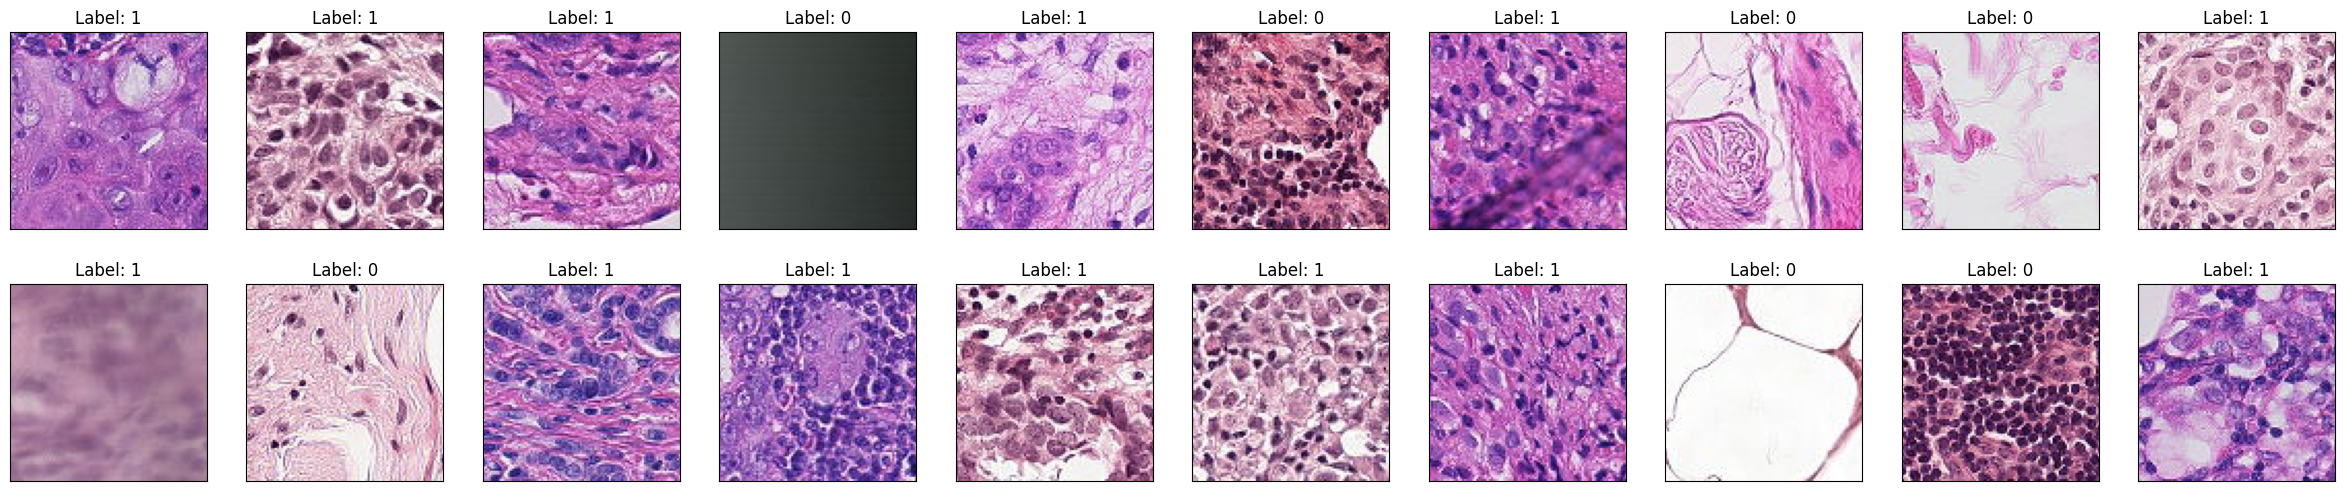

In [3]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(BASE_DIR+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(BASE_DIR+"train/" + img)
    plt.imshow(im)
    label = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

We can see some random images here from the training set. It is very difficult, especially for someone like me without a medical background, to tell which ones are cancerous and which ones aren't without the labels.

In [4]:
np.array(im).shape

(96, 96, 3)

<Axes: ylabel='count'>

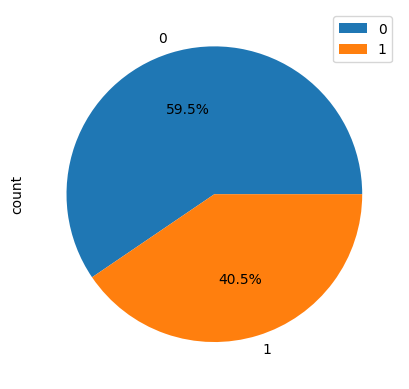

In [5]:
train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.1f%%')

Since this project is going to use keras, we will need to prepare a keras dataset. Keras utils method `image_dataset_from_directory` does not support tif files at the time of this writing. As such, the files need to be converted to something supported by the method.

In [6]:
def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
#         label = train_df[train_df['id'] == image_name]['label'].iloc[0]
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(BASE_DIR + f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)

In [7]:
import multiprocessing
from tqdm import tqdm

def convert_image_wrapper(args):
    return convert_image(*args)

def process_images(image_files, labels=[], with_label=True, subset='train'):
    num_processes = multiprocessing.cpu_count()
    
    with multiprocessing.Pool(processes=num_processes) as pool:
        tasks = [(filename, labels[index] if with_label else 0, with_label, subset) for index, filename in enumerate(image_files)]
        for _ in tqdm(pool.imap_unordered(convert_image_wrapper, tasks), total=len(tasks)):
            pass

In [8]:
# This process takes some time (10+ minutes)
process_images((train_df['id']+'.tif').values.tolist(), labels=train_df['label'].values.tolist())

100%|██████████| 220025/220025 [09:47<00:00, 374.65it/s]


In [9]:
process_images(os.listdir(BASE_DIR+"test"), with_label=False, subset='test')

100%|██████████| 57458/57458 [03:03<00:00, 313.36it/s]


Now we should have PNG equivalent of the training data separated into different folders based on their classes. We should be able to load the datasets.

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', label_mode='binary', image_size=(96,96), seed=42, validation_split=0.2,subset='training',batch_size=128)

val_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', label_mode='binary', image_size=(96,96), seed=42, validation_split=0.2, subset='validation',batch_size=128)


Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [11]:
test_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/test',label_mode=None,image_size=(96,96),shuffle=False,batch_size=1)

Found 57458 files belonging to 1 classes.


# Developing the Model

Since we have the datasets ready, we can continue with model development.

I decided to first trying to build a completely custom model. The model consists of three convolutional layers for feature extraction followed by three dense layers for classification. 

The convolutional layers have max pooling in between them. 

The dense layers utilize the ReLU activation function, except for the output layer which uses sigmoid.

In [12]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         3

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1376/1376 [==============================] - 309s 222ms/step - loss: 0.4550 - accuracy: 0.7893 - val_loss: 0.3968 - val_accuracy: 0.8243
Epoch 2/10
1376/1376 [==============================] - 283s 205ms/step - loss: 0.3680 - accuracy: 0.8379 - val_loss: 0.3493 - val_accuracy: 0.8488
Epoch 3/10
1376/1376 [==============================] - 284s 206ms/step - loss: 0.3255 - accuracy: 0.8608 - val_loss: 0.3248 - val_accuracy: 0.8586
Epoch 4/10
1376/1376 [==============================] - 273s 198ms/step - loss: 0.3007 - accuracy: 0.8726 - val_loss: 0.2912 - val_accuracy: 0.8769
Epoch 5/10
1376/1376 [==============================] - 298s 216ms/step - loss: 0.2787 - accuracy: 0.8839 - val_loss: 0.2850 - val_accuracy: 0.8812
Epoch 6/10
1376/1376 [==============================] - 276s 200ms/step - loss: 0.2645 - accuracy: 0.8898 - val_loss: 0.2850 - val_accuracy: 0.8841
Epoch 7/10
1376/1376 [==============================] - 309s 224ms/step - loss: 0.2527 - accuracy: 0.8958 - val_

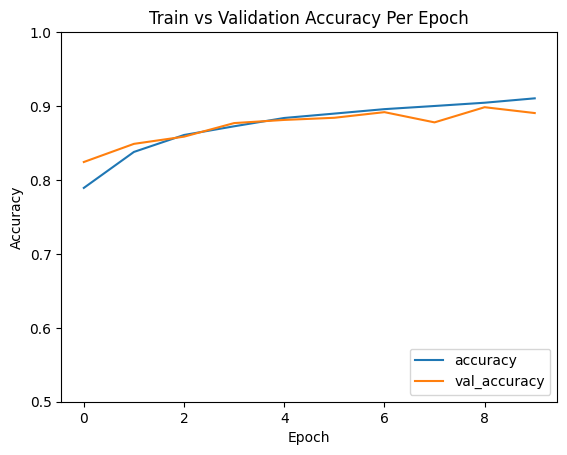

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Train vs Validation Loss Per Epoch')

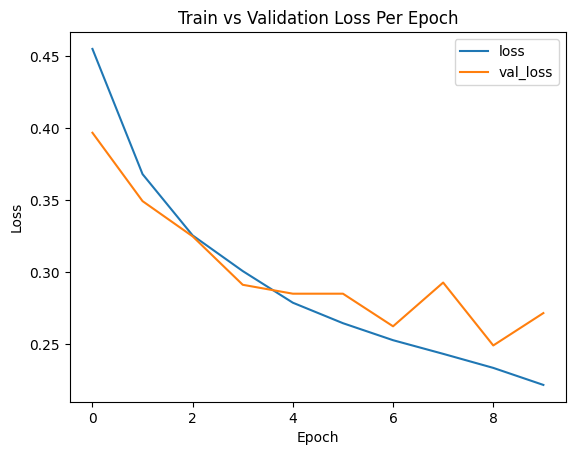

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

With __86%__ accuracy in the validation set, the model performed reasonably well. Based on the graphs, we can see that the model might be overfitting after the fourth epoch, as validation loss and accuracy both started to decrease from that point. 

Now lets create a submission entry for the competition. This requires a CSV file with ID and labels based on the provided test data.

In [17]:
test_imgs = os.listdir("/kaggle/working/png/test")
model1_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)

In [18]:
predictions = model.predict(test_dataset)

57458/57458 [==============================] - 152s 3ms/step


In [19]:
model1_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model1_pred_df['label'] = np.round(predictions.flatten()).astype('int')
model1_pred_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,1


In [20]:
model1_pred_df.to_csv('custom_model_predictions.csv', index=False)

After submitting the model to the competition, it was observed that it achieved a public score of **0.8239**.

Then I ventured to developing a model with ImageNet as the base model. Using ImageNet's weights, the dense layers were applied similar to the custom model.

In [21]:
from tensorflow.keras.applications import VGG16
base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = prediction_layer(x)
imagenet_model = tf.keras.Model(inputs, outputs)
imagenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                81984     
                                                                 
 dense_5 (Dense)             (None, 32)                2080  

In [23]:
base_learning_rate = 0.001
imagenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
imagenet_history = imagenet_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1376/1376 [==============================] - 1287s 932ms/step - loss: 0.4841 - accuracy: 0.7694 - val_loss: 0.4514 - val_accuracy: 0.7880
Epoch 2/10
1376/1376 [==============================] - 1263s 917ms/step - loss: 0.4572 - accuracy: 0.7861 - val_loss: 0.4346 - val_accuracy: 0.7981
Epoch 3/10
1376/1376 [==============================] - 1245s 905ms/step - loss: 0.4491 - accuracy: 0.7908 - val_loss: 0.4426 - val_accuracy: 0.7946
Epoch 4/10
1376/1376 [==============================] - 1252s 910ms/step - loss: 0.4439 - accuracy: 0.7931 - val_loss: 0.4301 - val_accuracy: 0.8010
Epoch 5/10
1376/1376 [==============================] - 1211s 879ms/step - loss: 0.4415 - accuracy: 0.7954 - val_loss: 0.4275 - val_accuracy: 0.8023
Epoch 6/10
1376/1376 [==============================] - 1233s 896ms/step - loss: 0.4388 - accuracy: 0.7968 - val_loss: 0.4232 - val_accuracy: 0.8051
Epoch 7/10
1376/1376 [==============================] - 1227s 892ms/step - loss: 0.4347 - accuracy: 0.7984

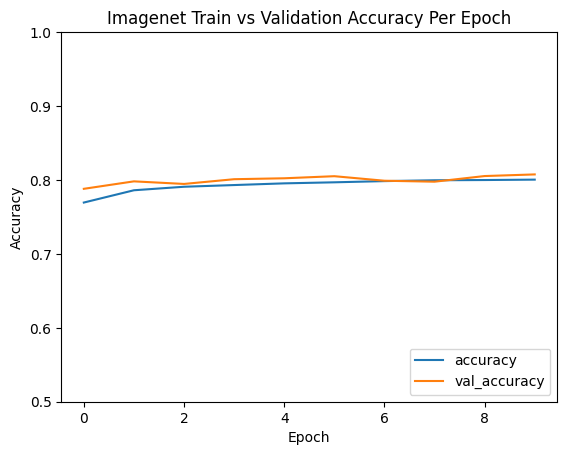

In [25]:
plt.plot(imagenet_history.history['accuracy'], label='accuracy')
plt.plot(imagenet_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Imagenet Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Imagenet Train vs Validation Loss Per Epoch')

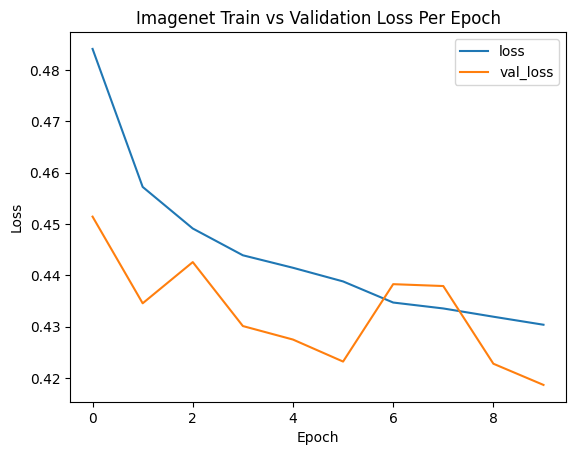

In [26]:
plt.plot(imagenet_history.history['loss'], label='loss')
plt.plot(imagenet_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Imagenet Train vs Validation Loss Per Epoch')

Interestingly, the accuracy for both validation and training data remained almost constant throughout the training. The loss for both steadily went down (apart from at the fifth epoch for validation where something wild happened).

Let's try predicting test results with this model.

In [27]:
model2_pred_df = pd.DataFrame(columns=['id', 'label'])
imagenet_predictions = imagenet_model.predict(test_dataset)


57458/57458 [==============================] - 956s 17ms/step


In [28]:
model2_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model2_pred_df['label'] = np.round(imagenet_predictions.flatten()).astype('int')
model2_pred_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,1


In [29]:
model2_pred_df.to_csv('imagenet_predictions.csv', index=False)

Upon submitting, the results from ImageNet model to the competition, a public score of **0.7855** was achieved.

# Results and Analysis

The project explored two distinct CNN models for histopathologic cancer detection: a custom-built model and an ImageNet-based model. The custom model, comprising three convolutional layers with max pooling and three dense layers, achieved a validation accuracy of 86% and demonstrated potential overfitting beyond the fourth epoch. This was evident as both validation loss and accuracy began to decrease. The model scored 0.8239 in the Kaggle competition. 

In contrast, the ImageNet-based model maintained stable performance throughout training, with an unexpected fluctuation in the fifth epoch. Despite its stability, it scored slightly lower in the competition at 0.7855.

| Model Type | Validation Accuracy | Stability | Competition Score | Remarks |
| -----------|---------------------|-----------|-------------------|---------|
| Custom Model | 86% | Low | 0.8239 | Overfitting after 4th epoch |
| ImageNet-Based | 80% | High | 0.7855 | Consistent performance |


## Troubleshooting and Future Considerations

For the custom model, implementing techniques such as dropout, early stopping, or adding regularization could help mitigate overfitting. For the ImageNet-based model, exploring different architectures or fine-tuning additional layers might improve its ability to capture more complex patterns in the data.

In summary, both models provide foundational insights for histopathologic cancer detection, yet each requires specific adjustments to fully optimize their performance. Future work should focus on balancing model complexity with the ability to generalize, along with exploring systematic hyperparameter optimization strategies.

# Conclusion

In this project, we investigated the application of CNNs for histopathologic cancer detection, utilizing two distinct models: a custom-built model and an ImageNet-based model. The custom model exhibited notable accuracy, reaching 86%, although it displayed a tendency to overfit after the fourth epoch. Despite this overfitting issue, the custom model achieved a Kaggle competition score of 0.8239, indicating its effectiveness in cancer detection.

On the other hand, the ImageNet-based model demonstrated stability throughout training but achieved a lower Kaggle competition score of 0.7855. This suggests that the ImageNet model might not fully capture the intricacies and complexity present in the dataset.

It's worth noting that no hyperparameter optimization was conducted in this study, leaving room for future improvement. The observed strengths of each model – the custom model excelling in accuracy and the ImageNet model in stability – underscore the need for a balanced approach in model design. Future endeavors could explore a combination of the strengths of both models and involve systematic hyperparameter optimization to enhance performance and generalization capabilities. This project underscores the potential of CNNs in medical imaging while emphasizing the importance of fine-tuning model parameters for optimal results.